In [1]:
import h5py
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
import torch.nn as nn 
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import sklearn
from pytorch_lightning.metrics.functional import accuracy
from sklearn.manifold import TSNE,MDS
from  matplotlib.colors import  rgb2hex
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
import os
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline

D:\Conda\envs\TorchLight\lib\site-packages\pytorch_lightning\utilities\distributed.py:22: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
class AEDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        #super(self).__init__()
        data = h5py.File('./samples/dataset_CNN.mat', 'r')
        self.train = train
        if self.train:
            train_x = np.array(data['train_x'])
            train_y = np.transpose(data['train_y']) 
            train_y -= 1

            self.train_x = torch.from_numpy(train_x).unsqueeze(1).float()
            self.train_y = torch.from_numpy(train_y).squeeze().long()
            #self.train_y = F.one_hot(train_y)

            print("train_x.shape:", self.train_x.shape)
            print("train_y.shape:", self.train_y.shape)
        else:
            test_x = np.array(data['test_x'])
            test_y = np.transpose(data['test_y'])
            test_y -= 1 

            self.test_x = torch.from_numpy(test_x).unsqueeze(1).float()
            self.test_y = torch.from_numpy(test_y).squeeze().long()
            #self.test_y = F.one_hot(test_y)

            print("test_x.shape:", self.test_x.shape)
            print("test_y.shape:", self.test_y.shape)

    def __len__(self):
        if self.train:
            return len(self.train_x)
        else:
            return len(self.test_x)

    def __getitem__(self, index):
        if self.train:
            x, y = self.train_x[index], self.train_y[index]
        else:
            x, y = self.test_x[index], self.test_y[index]

        return x, y

class MyDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        train_dataset = AEDataset(train=True)
        test_dataset = AEDataset(train=False)
        N = len(train_dataset)
        N_train = int(0.6*N)
        N_valid = int(0.4*N)
        train, valid = random_split(train_dataset, [N_train, N_valid])
        self.train_dataset = train
        self.val_dataset = valid
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=128, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=128, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=128, shuffle=False)

class CNNModel(pl.LightningModule):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 30, 9, 3),
            nn.ELU(),
            nn.Conv1d(30, 25, 9, 3),
            nn.ELU(),
            nn.Conv1d(25, 20, 9, 3),
            nn.ELU(),
            nn.MaxPool1d(3),
            nn.Flatten(),
            nn.Linear(720, 500),
            nn.ELU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 300),
            nn.ELU(),
            nn.BatchNorm1d(300),
            nn.Linear(300, 200),
            nn.ELU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 120),
            nn.ELU(),
            nn.BatchNorm1d(120),
            nn.Linear(120, 60)
            #nn.ELU(),,
        )
        #self.features = nn.Linear(60, 40)
        self.classification = nn.Sequential(
            nn.Linear(60, 6),
            #nn.Softmax()
            #nn.Sigmoid()
        ) 
            
    def forward(self, x):
        #called with self(x)
        features = self.cnn(x)
        output = self.classification(features)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_fun = nn.CrossEntropyLoss()
        loss = loss_fun(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #print('val_x.shape', x.shape)
        y_hat = self(x)
        loss_fun = nn.CrossEntropyLoss()
        loss = loss_fun(y_hat, y)
        tensorboard_logs = {'val_loss': loss}
        return {'val_loss': loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #print('y_hat.shape', y_hat.shape)
        #print('y.shape', y.shape)
        loss_fun = nn.CrossEntropyLoss()
        loss = loss_fun(y_hat, y)
        labels_hat = torch.argmax(y_hat, dim=1)
        test_acc = accuracy(labels_hat, y)
        #test_acc = (y_hat == y).sum()
        test_output = {'test_loss': loss, 'test_acc': test_acc}
        return test_output

    def test_epoch_end(self, test_step_outputs):
        test_epoch_loss = torch.stack([x['test_loss'] for x in test_step_outputs]).mean()
        test_epoch_acc = torch.stack([x['test_acc'] for x in test_step_outputs]).mean()
        return {
            'test_loss': test_epoch_loss,
            'log':{'avg_test_loss': test_epoch_loss, 'avg_test_acc': test_epoch_acc}
        }

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters())


In [3]:
model = CNNModel.load_from_checkpoint('./checkpoint/epoch=94.ckpt')
#print(model)
dm = MyDataModule()
checkpoint_callback = ModelCheckpoint(
filepath='./checkpoint',
save_top_k=1,
#verbose=True,
monitor='val_loss',
mode='min',
#prefix=''
)

logger = TensorBoardLogger(
save_dir=os.getcwd(),
version=2,
name='lightning_logs'
)
trainer = pl.Trainer(gpus=1, logger=logger, max_epochs=100, min_epochs=10, checkpoint_callback=checkpoint_callback,
                     progress_bar_refresh_rate=20)

trainer.fit(model, dm)
trainer.save_checkpoint("./checkpoint/cnn.ckpt")

KeyboardInterrupt: 

In [4]:
model = CNNModel.load_from_checkpoint('./checkpoint/cnn.ckpt')
# test_dataset = AEDataset(train=False)
# test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
dm = MyDataModule()
# print("test_dataloader", len(test_dataloader))
logger = TensorBoardLogger(
save_dir=os.getcwd(),
version=2,
name='lightning_logs'
)
trainer = pl.Trainer(gpus=1,logger=logger)
trainer.test(model, datamodule=dm)

train_x.shape: torch.Size([100000, 1, 3000])
train_y.shape: torch.Size([100000])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


test_x.shape: torch.Size([10000, 1, 3000])
test_y.shape: torch.Size([10000])
Testing:  95%|████████████████████████████████████████████████████████████████████▎   | 75/79 [00:00<00:00, 186.34it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_acc': tensor(0.9926, device='cuda:0'),
 'avg_test_loss': tensor(82613600., device='cuda:0'),
 'test_loss': tensor(82613600., device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 182.51it/s]


[{'avg_test_loss': 82613600.0,
  'avg_test_acc': 0.9925830960273743,
  'test_loss': 82613600.0}]

In [5]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 14384), started 18:33:31 ago. (Use '!kill 14384' to kill it.)

In [6]:
cnn = model.cnn
dataset = AEDataset(train=False)
test_x = dataset.test_x.cuda()
test_y = dataset.test_y
feature_output = cnn(test_x)

test_x.shape: torch.Size([10000, 1, 3000])
test_y.shape: torch.Size([10000])


(10000, 2)


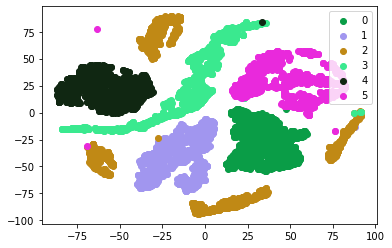

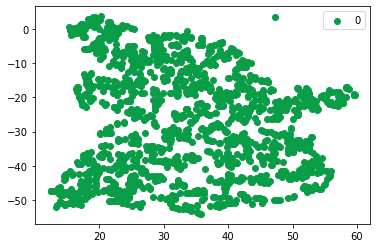

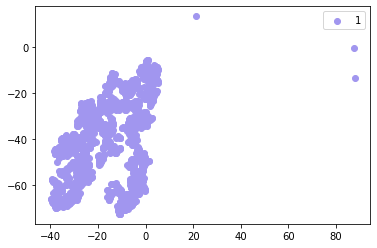

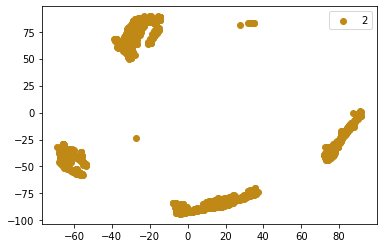

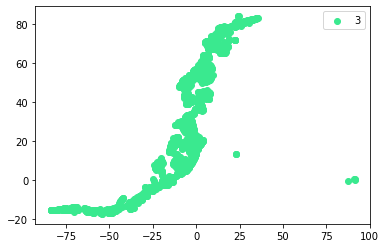

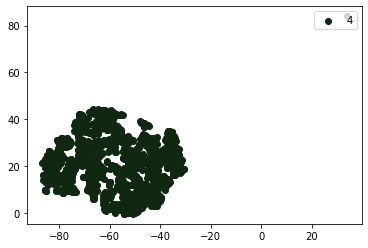

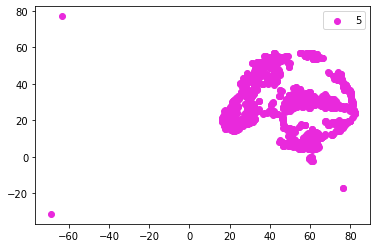

In [7]:
fig, ax = plt.subplots()
feature_output = feature_output.cpu().detach().numpy()
test_y = test_y.detach().numpy()

tsne=TSNE()
vis_feature=tsne.fit_transform(feature_output) 
##embedding = MDS(n_components=2)
#vis_feature = embedding.fit_transform(np.float32(feature_output))
print(vis_feature.shape)

# plot_feature=np.hstack((vis_feature,test_y))
# print(plot_feature.shape)

colors = tuple([(np.random.random(),np.random.random(), np.random.random()) for i in range(6)])
colors = [rgb2hex(x) for x in colors]  # from  matplotlib.colors import  rgb2hex

#print(plot_feature[1001])
for i, color in enumerate(colors):
    #print(i)
    need_idx = np.where(test_y==i)[0]
  #print(need_idx)
    ax.scatter(vis_feature[need_idx,0],vis_feature[need_idx,1], c=color, label=i)

for i, color in enumerate(colors):
  #print(i)
    need_idx = np.where(test_y==i)[0]
  #print(need_idx)
    fig1, ax1 = plt.subplots()
    ax1.scatter(vis_feature[need_idx,0],vis_feature[need_idx,1], c=color, label=i)
    legend2 = ax1.legend(loc='upper right')


# 改变坐标轴间隔
# x_locator = MultipleLocator(0.01)
# y_locator = MultipleLocator(0.01)
# ax = plt.gca()
# ax.xaxis.set_major_locator(x_locator)
# ax.yaxis.set_major_locator(y_locator)
 
legend = ax.legend(loc='upper right')
plt.savefig("cluster.png")
